## Deep Learning - 이미지 처리 전이학습(Transfer Learning) 이용한 이미지 분류 모델 구현 실습


인터넷 자료 참조

CIFAR-10은 10개의 클래스(예: 비행기, 자동차, 새, 고양이 등)를 가진 50,000장의 32x32 크기의 컬러 학습 이미지와 10,000장의 테스트 이미지로 구성되어 있다.

### 전이학습(Transfer Learning)을 이용한 cifar10 분류작업

(50000, 32, 32, 3)


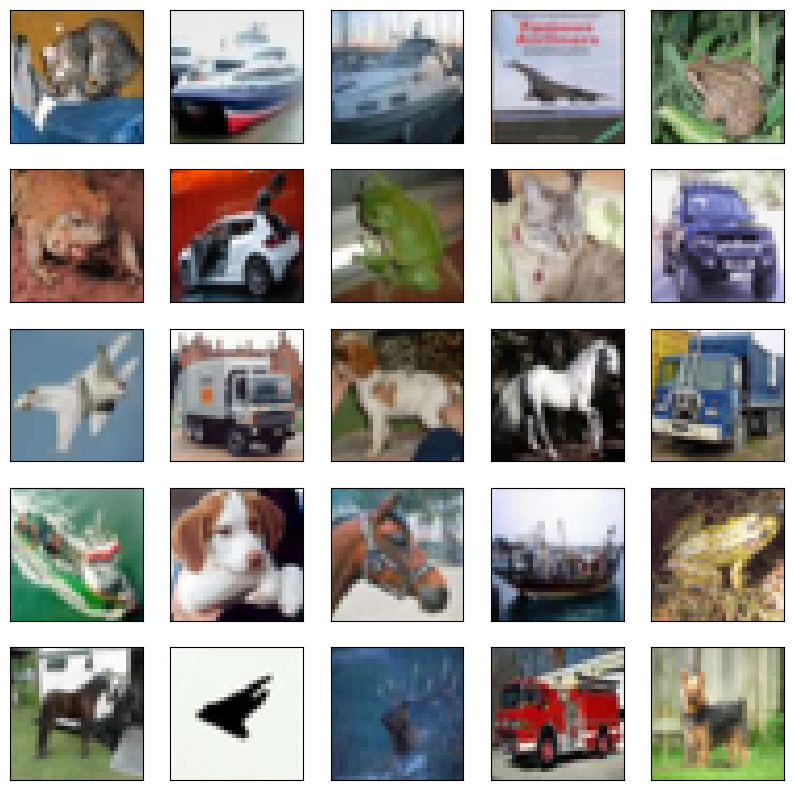

In [4]:
from tensorflow.keras import datasets

# 케라스 데이터셋을 다운받아 변수에 각각 넣어준다.
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

print(train_images.shape)
# 이미지 불러보기
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i], cmap=plt.cm.binary)
plt.show()

In [5]:
from tensorflow.keras.applications.resnet50 import ResNet50
base_model = ResNet50(include_top=True, input_shape = (224, 224 ,3), weights = 'imagenet')

In [24]:
# base_model.summary()

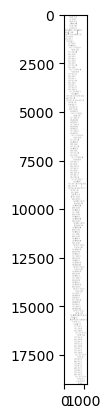

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

# 모델 그림 그리기
plot_model(base_model, to_file='ResNet50.png', show_shapes=True, show_layer_names=True)

# 모델 그림 화면에 출력
img = plt.imread('ResNet50.png')
plt.imshow(img)
plt.show()

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D
from tensorflow.keras import datasets
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import Input
from tensorflow.keras.layers import Dropout, BatchNormalization

In [25]:
# 데이터셋 불러오기
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

base_model = ResNet50(include_top=False, pooling = 'avg' , input_shape = (32,32 ,3), weights = 'imagenet')
base_model.trainable = False

input_y = tf.keras.utils.to_categorical(train_labels, 10)
test_y = tf.keras.utils.to_categorical(test_labels, 10)

inputs = Input(shape=(32,32,3))
x = tf.keras.layers.experimental.preprocessing.Resizing(32, 32)(inputs)
x = tf.keras.applications.resnet50.preprocess_input(inputs)
x = base_model(x, training = False)
x = Flatten()(x) 
outputs = Dense(10, activation = 'softmax')(x) 
model_res = tf.keras.Model(inputs, outputs)

In [26]:
model_res.compile(optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])


early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


model_res.fit(train_images, input_y, epochs = 2, validation_data=(test_images, test_y), batch_size= 256, callbacks=[early])

Epoch 1/2
196/196 [==============================] - 45s 222ms/step - loss: 1.6729 - accuracy: 0.5387 - val_loss: 1.2350 - val_accuracy: 0.6098
Epoch 2/2
196/196 [==============================] - 41s 208ms/step - loss: 1.0811 - accuracy: 0.6420 - val_loss: 1.1339 - val_accuracy: 0.6335


## 전이학습 미세조정(fine tuning)

Fine-tuning (선택 사항): 사전 학습된 가중치를 불러오고 나서, 추가로 모델을 학습시킬 수도 있다. 이를 fine-tuning이라고 하며, 이 과정에서는 모델의 일부 레이어를 동결하고 (즉, 학습에서 제외하고), 나머지 레이어를 학습한다. 이 방법은 새로운 문제와 원래 문제가 매우 다른 경우에 특히 유용하다.

In [11]:
save = model_res.fit(train_images, input_y, epochs = 10, validation_data=(test_images, test_y), batch_size= 256, callbacks=[early])

Epoch 1/10
196/196 [==============================] - 39s 198ms/step - loss: 0.7830 - accuracy: 0.7274 - val_loss: 1.1116 - val_accuracy: 0.6485
Epoch 2/10
196/196 [==============================] - 39s 197ms/step - loss: 0.7778 - accuracy: 0.7287 - val_loss: 1.0978 - val_accuracy: 0.6513
Epoch 3/10
196/196 [==============================] - 38s 196ms/step - loss: 0.7768 - accuracy: 0.7298 - val_loss: 1.1288 - val_accuracy: 0.6467
Epoch 4/10
196/196 [==============================] - 38s 196ms/step - loss: 0.7749 - accuracy: 0.7299 - val_loss: 1.1442 - val_accuracy: 0.6405
Epoch 5/10
196/196 [==============================] - 38s 195ms/step - loss: 0.7762 - accuracy: 0.7317 - val_loss: 1.1445 - val_accuracy: 0.6480
Epoch 6/10
196/196 [==============================] - 38s 194ms/step - loss: 0.7665 - accuracy: 0.7323 - val_loss: 1.1316 - val_accuracy: 0.6504
Epoch 7/10
196/196 [==============================] - 38s 192ms/step - loss: 0.7688 - accuracy: 0.7341 - val_loss: 1.1471 - val_ac

In [19]:
save = model_res.fit(train_images, input_y, epochs = 1, validation_data=(test_images, test_y), batch_size= 256, callbacks=[early])

196/196 [==============================] - 457s 2s/step - loss: 0.7127 - accuracy: 0.7521 - val_loss: 0.9054 - val_accuracy: 0.6954


In [20]:
save

미세조정을 위한 resnet 모델 일부 동결 해제

In [21]:
base_model.trainable = True 
for i in base_model.layers[:143]: 
  i.trainable = False 
  
for i in base_model.layers[140:]: 
  print(i.name, i.trainable)

conv4_block6_3_bn False
conv4_block6_add False
conv4_block6_out False
conv5_block1_1_conv True
conv5_block1_1_bn True
conv5_block1_1_relu True
conv5_block1_2_conv True
conv5_block1_2_bn True
conv5_block1_2_relu True
conv5_block1_0_conv True
conv5_block1_3_conv True
conv5_block1_0_bn True
conv5_block1_3_bn True
conv5_block1_add True
conv5_block1_out True
conv5_block2_1_conv True
conv5_block2_1_bn True
conv5_block2_1_relu True
conv5_block2_2_conv True
conv5_block2_2_bn True
conv5_block2_2_relu True
conv5_block2_3_conv True
conv5_block2_3_bn True
conv5_block2_add True
conv5_block2_out True
conv5_block3_1_conv True
conv5_block3_1_bn True
conv5_block3_1_relu True
conv5_block3_2_conv True
conv5_block3_2_bn True
conv5_block3_2_relu True
conv5_block3_3_conv True
conv5_block3_3_bn True
conv5_block3_add True
conv5_block3_out True
avg_pool True


In [22]:
model_res.compile(optimizer = tf.keras.optimizers.Adam( learning_rate= 0.0001),
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])

early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model_res.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 tf.__operators__.getitem (  (None, 32, 32, 3)         0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 32, 32, 3)         0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 10)                20490 

In [23]:
save_fine = model_res.fit(train_images, input_y, epochs = 2, initial_epoch = save.epoch[-1],validation_data=(test_images, test_y), batch_size= 256, callbacks = [early])

Epoch 1/2
196/196 [==============================] - 490s 2s/step - loss: 0.4816 - accuracy: 0.8326 - val_loss: 0.9318 - val_accuracy: 0.7021
Epoch 2/2
196/196 [==============================] - 488s 2s/step - loss: 0.2606 - accuracy: 0.9167 - val_loss: 0.9521 - val_accuracy: 0.7115


## 전이학습 모델의 구조만 가져와 학습하기

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D
from tensorflow.keras import datasets

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

from tensorflow.keras.applications.resnet50 import ResNet50
base_model = ResNet50(include_top=False, pooling = 'avg' , input_shape = (32,32 ,3), weights = None)

base_model.trainable =True

input_y = tf.keras.utils.to_categorical(train_labels, 10)
test_y = tf.keras.utils.to_categorical(test_labels, 10)

from tensorflow.keras import Input

inputs = Input(shape=(32,32,3))
x = tf.keras.applications.resnet50.preprocess_input(inputs)
x = base_model(x, training=False)
x = Flatten()(x)
outputs = Dense(10, activation = 'softmax')(x)
model_res = tf.keras.Model(inputs, outputs

ResNet50 모델을 로드하고 있다. include_top=False는 ResNet50의 마지막 레이어(즉, fully connected layer)를 제외하겠다는 의미이며, 이를 통해 우리의 문제에 맞게 레이어를 추가할 수 있다. pooling='avg'는 마지막 convolutional 레이어 후에 global average pooling을 적용하겠다는 것을 의미한다. input_shape=(32,32,3)은 입력 이미지의 크기를 지정하는 것이며, CIFAR-10의 이미지 크기와 동일하다. weights=None은 사전 학습된 가중치를 사용하지 않겠다는 의미이다.

input_y = tf.keras.utils.to_categorical(train_labels, 10) test_y = tf.keras.utils.to_categorical(test_labels, 10)

이 코드는 레이블을 원-핫 인코딩으로 변환한다. 예를 들어, 클래스 레이블이 4인 경우, 원-핫 인코딩은 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]이 된다.




In [ ]:
model_res.compile(optimizer = 'adam', loss= 'categorical_crossentropy', metrics=['accuracy'])
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience= 5)

model_res.fit(train_images, input_y, epochs=30, batch_size=256, validation_data=(test_images, test_y), callbacks=[early])